In [1]:
from param import Param
from sde import *
from fparam import *
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
# We used analytically calibrated heston model
params = {
    "h_0"  : Param(0.0121),
    "theta": Param(0.016710961735659603),
    "rho"  : Param(-5.217506541926356e-14),
    "kappa": Param(1.8199032682313863),
    "xi"   : Param(0.09909295207412022),
    "dt"   : Param(1/252),
    "r"    : Param(0.0411),
    "S_0"  : Param(100)
}

# Model functions
def feller(params):
    k     = params["kappa"].eval()
    theta = params["theta"].eval()
    xi    = params["xi"].eval()
    return 2 * k * theta > xi * xi

def mu_h(h_t, t, params=None):
    k = params["kappa"].eval()
    theta = params["theta"].eval()
    return k * (theta - h_t)

def v_h(h_t, t, params=None):
    xi = params["xi"].eval()
    return xi * math.sqrt(max(h_t, 0.))

def mu(S_t, t, params=None):
    r = params["r"].eval()
    return r * S_t

def v(S_t, t, cir, params=None):
    vol = cir.nodes[t-1].eval()
    return math.sqrt(max(vol, 0.)) * S_t

drift_h  = FParam(mu_h, params)
vol_h    = FParam(v_h, params)
T   = 252
N   = 100

cir_sim = EulerSimulation(drift_h, vol_h, params["h_0"], T, params["dt"], N)

drift_s = FParam(mu, params)
vol_s   = FParam(v, params)

simulation = StochVolSimulation(drift_s, vol_s, params["S_0"], cir_sim, T, params["dt"], N, rho=params["rho"].eval())

In [3]:
targets = {
    1: {95: 6.5757, 100: 2.8223, 105: 0.6335},
    2: {95: 8.1165, 100: 4.3850, 105: 1.7263},
    3: {100: 6.0865, 105: 3.1820, 110: 1.2347},
    4: {100: 7.7710, 105: 4.7369, 110: 2.4165}
}

def plot_sims(cir_sim, simulation):
    for i in range(N):
        plt.plot(cir_sim.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Daily Variance")
    plt.title("Variance Simulation")
    plt.show()

    for i in range(N):
        plt.plot(simulation.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Index Price")
    plt.title("Index Price Simulation")
    plt.show()
    
def call_price(result, targets, r):
    qt = T // 4
    out = dict()
    sse = 0.
    for m in targets:
        out[m] = dict()
        for strike in targets[m]:
            out[m][strike] = np.maximum((result[(qt*m), :] - strike), 0).mean() * np.exp(- r * qt * m * params["dt"].eval())
            sse += (out[m][strike] - targets[m][strike])**2
    return out, sse

def run_sims(cir_sim, simulation):
    cir_sim.run_all()
    simulation.run_all()

In [4]:
run_sims(cir_sim, simulation)
out, sse = call_price(simulation.results, targets, params["r"].eval())
opt_sse = sse
opt_out = out
print("SSE: = ", sse)
print("Call Prices = ", opt_out)

SSE: =  2.0851476935936315
Call Prices =  {1: {95: 6.356378242005502, 100: 2.471756173536803, 105: 0.6119620947846042}, 2: {95: 7.437138277412991, 100: 3.956683663614918, 105: 1.5002773140757433}, 3: {100: 5.38197116970378, 105: 2.621008265049025, 110: 0.9940594905849549}, 4: {100: 7.273204863902319, 105: 4.420495563492971, 110: 2.389387334861191}}


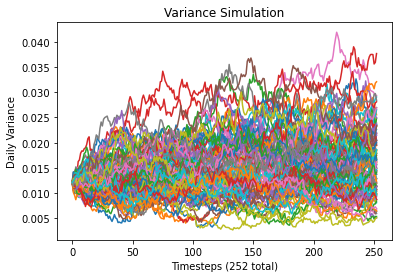

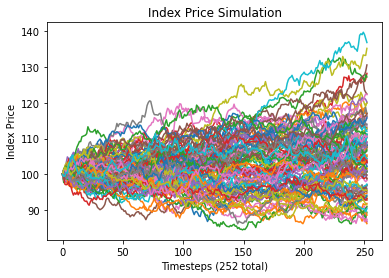

In [5]:
plot_sims(cir_sim, simulation)

In [6]:
# Manual Calibration
step = 10
theta_grid = np.linspace(0.016705, 0.01615, step)
kappa_grid = np.linspace(1.8195, 1.8205, step)
xi_grid    = np.linspace(0.09905, 0.09915, step)
opt_comb   = None
opt_sse    = -1.
opt_out    = None
ct = 0

for theta in theta_grid:
    for kappa in kappa_grid:
        ct += 1
        for xi in xi_grid:
            params["theta"].val = theta
            params["kappa"].val = kappa
            params["xi"].val    = xi
            if feller(params):
                run_sims(cir_sim, simulation)
                out, sse = call_price(simulation.results, targets, params["r"].eval())
                if opt_sse < 0. or sse < opt_sse:
                    opt_sse = sse
                    opt_comb = (theta, kappa, xi)
                    opt_out = out
    if ct % step == 0:
        print(f"Calibration {ct // step}/{step} complete.")

Calibration 1/10 complete.
Calibration 2/10 complete.
Calibration 3/10 complete.
Calibration 4/10 complete.
Calibration 5/10 complete.
Calibration 6/10 complete.
Calibration 7/10 complete.
Calibration 8/10 complete.
Calibration 9/10 complete.
Calibration 10/10 complete.


In [7]:
print("SSE: = ", sse)
print("Optimal Combination = ", opt_comb)
print("Call Prices = ", opt_out)

SSE: =  2.363737403037379
Optimal Combination =  (0.016705, 1.8205, 0.09905)
Call Prices =  {1: {95: 6.356352579787244, 100: 2.4717614518943236, 105: 0.6119689261223938}, 2: {95: 7.437079967041607, 100: 3.9566310361533543, 105: 1.5002426824253214}, 3: {100: 5.381939540176283, 105: 2.6210055293060344, 110: 0.9940577668841232}, 4: {100: 7.273145827525528, 105: 4.4204311698809935, 110: 2.389333792340585}}
